In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, applications
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import backend as K 

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [4]:
train.category = train.category.astype('str')

In [5]:
train.dtypes

image       object
category    object
dtype: object

In [6]:
# train.category = train.category.map(lambda x : str(x))

In [7]:
test.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [8]:
submission.head()

,image,category
0,1007700.jpg,1
1,1011369.jpg,1
2,1051155.jpg,1
3,1062001.jpg,1
4,1069397.jpg,1


In [9]:
tempdf = pd.DataFrame()

path = '/home/monster/Downloads/kaggle/AV-Ship_detection/images/'

imgID = os.listdir('images/')
imgpath = [path+i for i in os.listdir('images/')]

tempdf['image'] = imgID
tempdf['path'] = imgpath


In [10]:
tempdf.path[0]

'/home/monster/Downloads/kaggle/AV-Ship_detection/images/2821210.jpg'

In [11]:
tempdf.image[0]

'2821210.jpg'

In [12]:
tempdf.head()

,image,path
0,2821210.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...
1,2825104.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...
2,2818922.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...
3,2784265.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...
4,2841582.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...


In [13]:
train_merged = train.merge(tempdf,on='image',how='left')

In [14]:
train_merged.dtypes

image       object
category    object
path        object
dtype: object

In [15]:
train.shape,train_merged.shape

((6252, 2), (6252, 3))

In [16]:
train_merged.head()

,image,category,path
0,2823080.jpg,1,/home/monster/Downloads/kaggle/AV-Ship_detecti...
1,2870024.jpg,1,/home/monster/Downloads/kaggle/AV-Ship_detecti...
2,2662125.jpg,2,/home/monster/Downloads/kaggle/AV-Ship_detecti...
3,2900420.jpg,3,/home/monster/Downloads/kaggle/AV-Ship_detecti...
4,2804883.jpg,2,/home/monster/Downloads/kaggle/AV-Ship_detecti...


In [17]:
train_merged.apply(lambda x: sum(x.isnull()),axis=0)

image       0
category    0
path        0
dtype: int64

In [18]:
test_merged = test.merge(tempdf,on='image',how='left')

In [19]:
test.shape,test_merged.shape

((2680, 1), (2680, 2))

In [20]:
test_merged.head()

,image,path
0,1007700.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...
1,1011369.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...
2,1051155.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...
3,1062001.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...
4,1069397.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...


In [21]:
#image categories in train
train_merged.category.value_counts()

1    2120
5    1217
2    1167
3     916
4     832
Name: category, dtype: int64

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = train_merged[['image','path']]
y = train_merged[['category']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle =True,random_state=42)

In [24]:
X_train.shape,X_test.shape

((5939, 2), (313, 2))

In [25]:
train_df = pd.concat([X_train,y_train],axis=1)
valid_df = pd.concat([X_test,y_test],axis=1)

In [26]:
train_df.category.value_counts()

1    2021
5    1141
2    1117
3     867
4     793
Name: category, dtype: int64

In [27]:
valid_df.category.value_counts()

1    99
5    76
2    50
3    49
4    39
Name: category, dtype: int64

In [28]:
train_df.dtypes

image       object
path        object
category    object
dtype: object

In [29]:
valid_df.dtypes

image       object
path        object
category    object
dtype: object

In [30]:
train_df.head()

,image,path,category
4630,762412.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...,4
265,2325200.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...,4
4641,2909099.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...,3
5670,2498096.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...,2
1869,2704897.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...,2


In [31]:
valid_df.head()

,image,path,category
1703,2525185.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...,4
5448,2837639.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...,1
5058,2904577.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...,1
1149,2866290.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...,3
432,2459131.jpg,/home/monster/Downloads/kaggle/AV-Ship_detecti...,4


In [32]:
train_df.category.unique()

array(['4', '3', '2', '5', '1'], dtype=object)

In [33]:
valid_df.category.unique()

array(['4', '1', '3', '2', '5'], dtype=object)

In [34]:
# {'Cargo': 1, 
# 'Military': 2, 
# 'Carrier': 3, 
# 'Cruise': 4, 
# 'Tankers': 5}

In [35]:
nb_classes = 5
batch_size = 64
img_size = 224
nb_epochs = 50

In [57]:
# %%time
train_datagen=ImageDataGenerator(rescale=1./255, 
    validation_split=0.25,
    horizontal_flip = True,    
    zoom_range = 0.3,
    width_shift_range = 0.3,
    height_shift_range=0.3,
#     featurewise_center=True, 
#     featurewise_std_normalization=True
    )

#fit the generator obj 
# train_datagen.fit()

train_generator=train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="/home/monster/Downloads/kaggle/AV-Ship_detection/images/",
    x_col="image",
    y_col="category",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 5939 images belonging to 5 classes.


In [58]:
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory="/home/monster/Downloads/kaggle/AV-Ship_detection/images/",
    x_col="image",
    y_col="category",
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",    
    target_size=(img_size,img_size))

Found 313 images belonging to 5 classes.


In [59]:
model = applications.vgg16.VGG16(include_top=False, 
                                 weights=None, 
                                 input_shape=(img_size, img_size, 3))

In [ ]:
# model = applications.InceptionV3(weights=None, 
#                               include_top=False, 
#                               input_shape=(img_size, img_size, 3))

In [60]:
# model.load_weights('/home/monster/Downloads/kaggle/AV-Ship_detection/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

model.load_weights('/home/monster/Downloads/kaggle/AV-Ship_detection/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


In [61]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [62]:
len(model.layers)

19

In [63]:
# Freeze some layers
for layer in model.layers[:-15]:
    layer.trainable = False

In [43]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [64]:
#Adding custom layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(nb_classes, activation="softmax")(x)
model_final = Model(inputs = model.input, outputs = predictions)

# model_final.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy',f1])


model_final.compile(optimizers.Adam(lr=0.0001,decay=1e-6)
                    ,loss='categorical_crossentropy',
                    metrics=['accuracy',f1])

In [65]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [66]:
# Callbacks

checkpoint = ModelCheckpoint("vgg16_2.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [67]:
%%time
history = model_final.fit_generator(generator=train_generator,                   
                                    steps_per_epoch=200,
                                    validation_data=valid_generator,                    
                                    validation_steps=200,
                                    epochs=nb_epochs,
                                    callbacks = [checkpoint, early],
                                    verbose=2)

Epoch 1/50
 - 139s - loss: 1.5666 - acc: 0.3327 - f1: 0.0247 - val_loss: 1.5547 - val_acc: 0.3163 - val_f1: 0.0000e+00

Epoch 00001: val_loss improved from inf to 1.55465, saving model to vgg16_2.h5
Epoch 2/50
 - 133s - loss: 1.5528 - acc: 0.3405 - f1: 7.6691e-04 - val_loss: 1.5416 - val_acc: 0.3163 - val_f1: 0.0125

Epoch 00002: val_loss improved from 1.55465 to 1.54156, saving model to vgg16_2.h5
Epoch 3/50
 - 134s - loss: 1.4399 - acc: 0.3735 - f1: 0.1407 - val_loss: 1.0405 - val_acc: 0.5208 - val_f1: 0.4094

Epoch 00003: val_loss improved from 1.54156 to 1.04046, saving model to vgg16_2.h5
Epoch 4/50
 - 133s - loss: 1.2059 - acc: 0.4591 - f1: 0.3355 - val_loss: 1.0179 - val_acc: 0.5399 - val_f1: 0.4562

Epoch 00004: val_loss improved from 1.04046 to 1.01789, saving model to vgg16_2.h5
Epoch 5/50
 - 134s - loss: 0.8741 - acc: 0.6380 - f1: 0.5803 - val_loss: 0.6551 - val_acc: 0.7412 - val_f1: 0.7094

Epoch 00005: val_loss improved from 1.01789 to 0.65513, saving model to vgg16_2.h5
E

In [ ]:
#load model
from keras.models import load_model
# model = load_model('vgg16_1.h5')
m1 = load_model('vgg16_2.h5', custom_objects={'f1': f1})


In [ ]:
m1.summary()

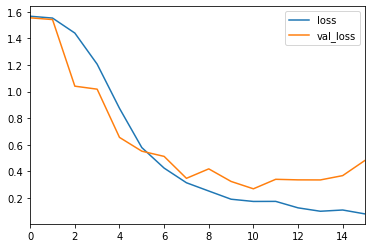

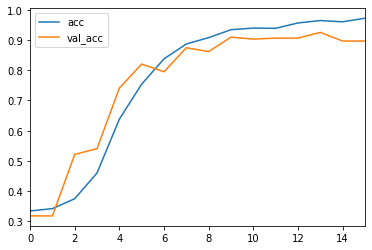

In [68]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
plt.show()

In [69]:
%%time

test_generator = test_datagen.flow_from_dataframe(      
    
        dataframe=test_merged,    
    
        directory = "/home/monster/Downloads/kaggle/AV-Ship_detection/images/",    
        x_col="path",
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 2680 images.
CPU times: user 36 ms, sys: 8 ms, total: 44 ms
Wall time: 42.1 ms


In [70]:
%%time
test_generator.reset()
predict=model_final.predict_generator(test_generator, steps = len(test_generator.filenames))

CPU times: user 25.3 s, sys: 1.2 s, total: 26.5 s
Wall time: 17.6 s


In [71]:
predicted_class_indices=np.argmax(predict,axis=1)

In [72]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [73]:
sam_sub_df = submission
sam_sub_df.head()

,image,category
0,1007700.jpg,1
1,1011369.jpg,1
2,1051155.jpg,1
3,1062001.jpg,1
4,1069397.jpg,1


In [74]:
filenames=test_generator.filenames
results=pd.DataFrame({"path":filenames,
                      "predicted":predictions})
df_res = pd.merge(test_merged, results, on='path')[['image','predicted']]\
#     .rename(columns={'image_id':'id'})

df_res.head()

,image,predicted
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [75]:
df_res.columns = ['image','category']

In [76]:
df_res.to_csv("submission_vgg3.csv",index=False)